<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [ ]:
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder

from sklearn.preprocessing import OneHotEncoder

from src.support_prep import *

In [166]:
df = pd.read_csv("datos/financial_data.csv")
df.duplicated().sum()

0

In [167]:
df.dtypes

transaction_id               int64
customer_id                  int64
merchant_id                  int64
amount                     float64
transaction_time            object
is_fraudulent                int64
card_type                   object
location                    object
purchase_category           object
customer_age                 int64
transaction_description     object
dtype: object

Para el proceso de creación de nuestro modelo hay algunas de las variables que podemos descartar, ya que no nos aportan información sobre la variable objetivo. Ya de primeras, `transaction_id` es una de esas, ya que representa un identificador único de cada una de las transacciones.
Otra posible a descartar podría ser la de transaction_time, ya que indica fechas, y las transacciones fraudulentas no deberían seguir una fecha determinada. Sin embargo, vamos a comprobar antes de actuar.

In [168]:
df.drop(columns = "transaction_id", inplace=True)

In [169]:
pd.to_datetime(df["transaction_time"]).apply(lambda x: x.strftime("%Y-%m-%d")).unique()

array(['2023-01-01'], dtype=object)

Solo hay 1 fecha. Dropeamos

In [170]:
df.drop(columns="transaction_time", inplace=True)

También podemos tener dudas sobre ``transaction_description``, ya que a primera vista contiene información del comercio donde se realizó la operación, que podría ser la misma info que en `merchant_id`, pero siempre es conveniente comprobar antes de actuar:

Vamos a eliminar la parte del string de la descripción y convertimos el id del merchant a int.

In [171]:
df["transaction_description"] = df["transaction_description"].str.replace("Purchase at Merchant-", "").astype(int)

In [172]:
(df["transaction_description"] == df["merchant_id"]).all()

True

Vemos que todos son iguales, por lo que nos aporta la misma información que `merchant_id` y podemos descartar las descripciones.

In [173]:
df.drop(columns="transaction_description", inplace=True)

In [174]:
df["merchant_id"] = df["merchant_id"].astype("str")
df["customer_id"] = df["customer_id"].astype("str")

In [175]:
cat_cols = df.select_dtypes('O').columns
num_cols = df.select_dtypes('number').columns.drop("is_fraudulent")

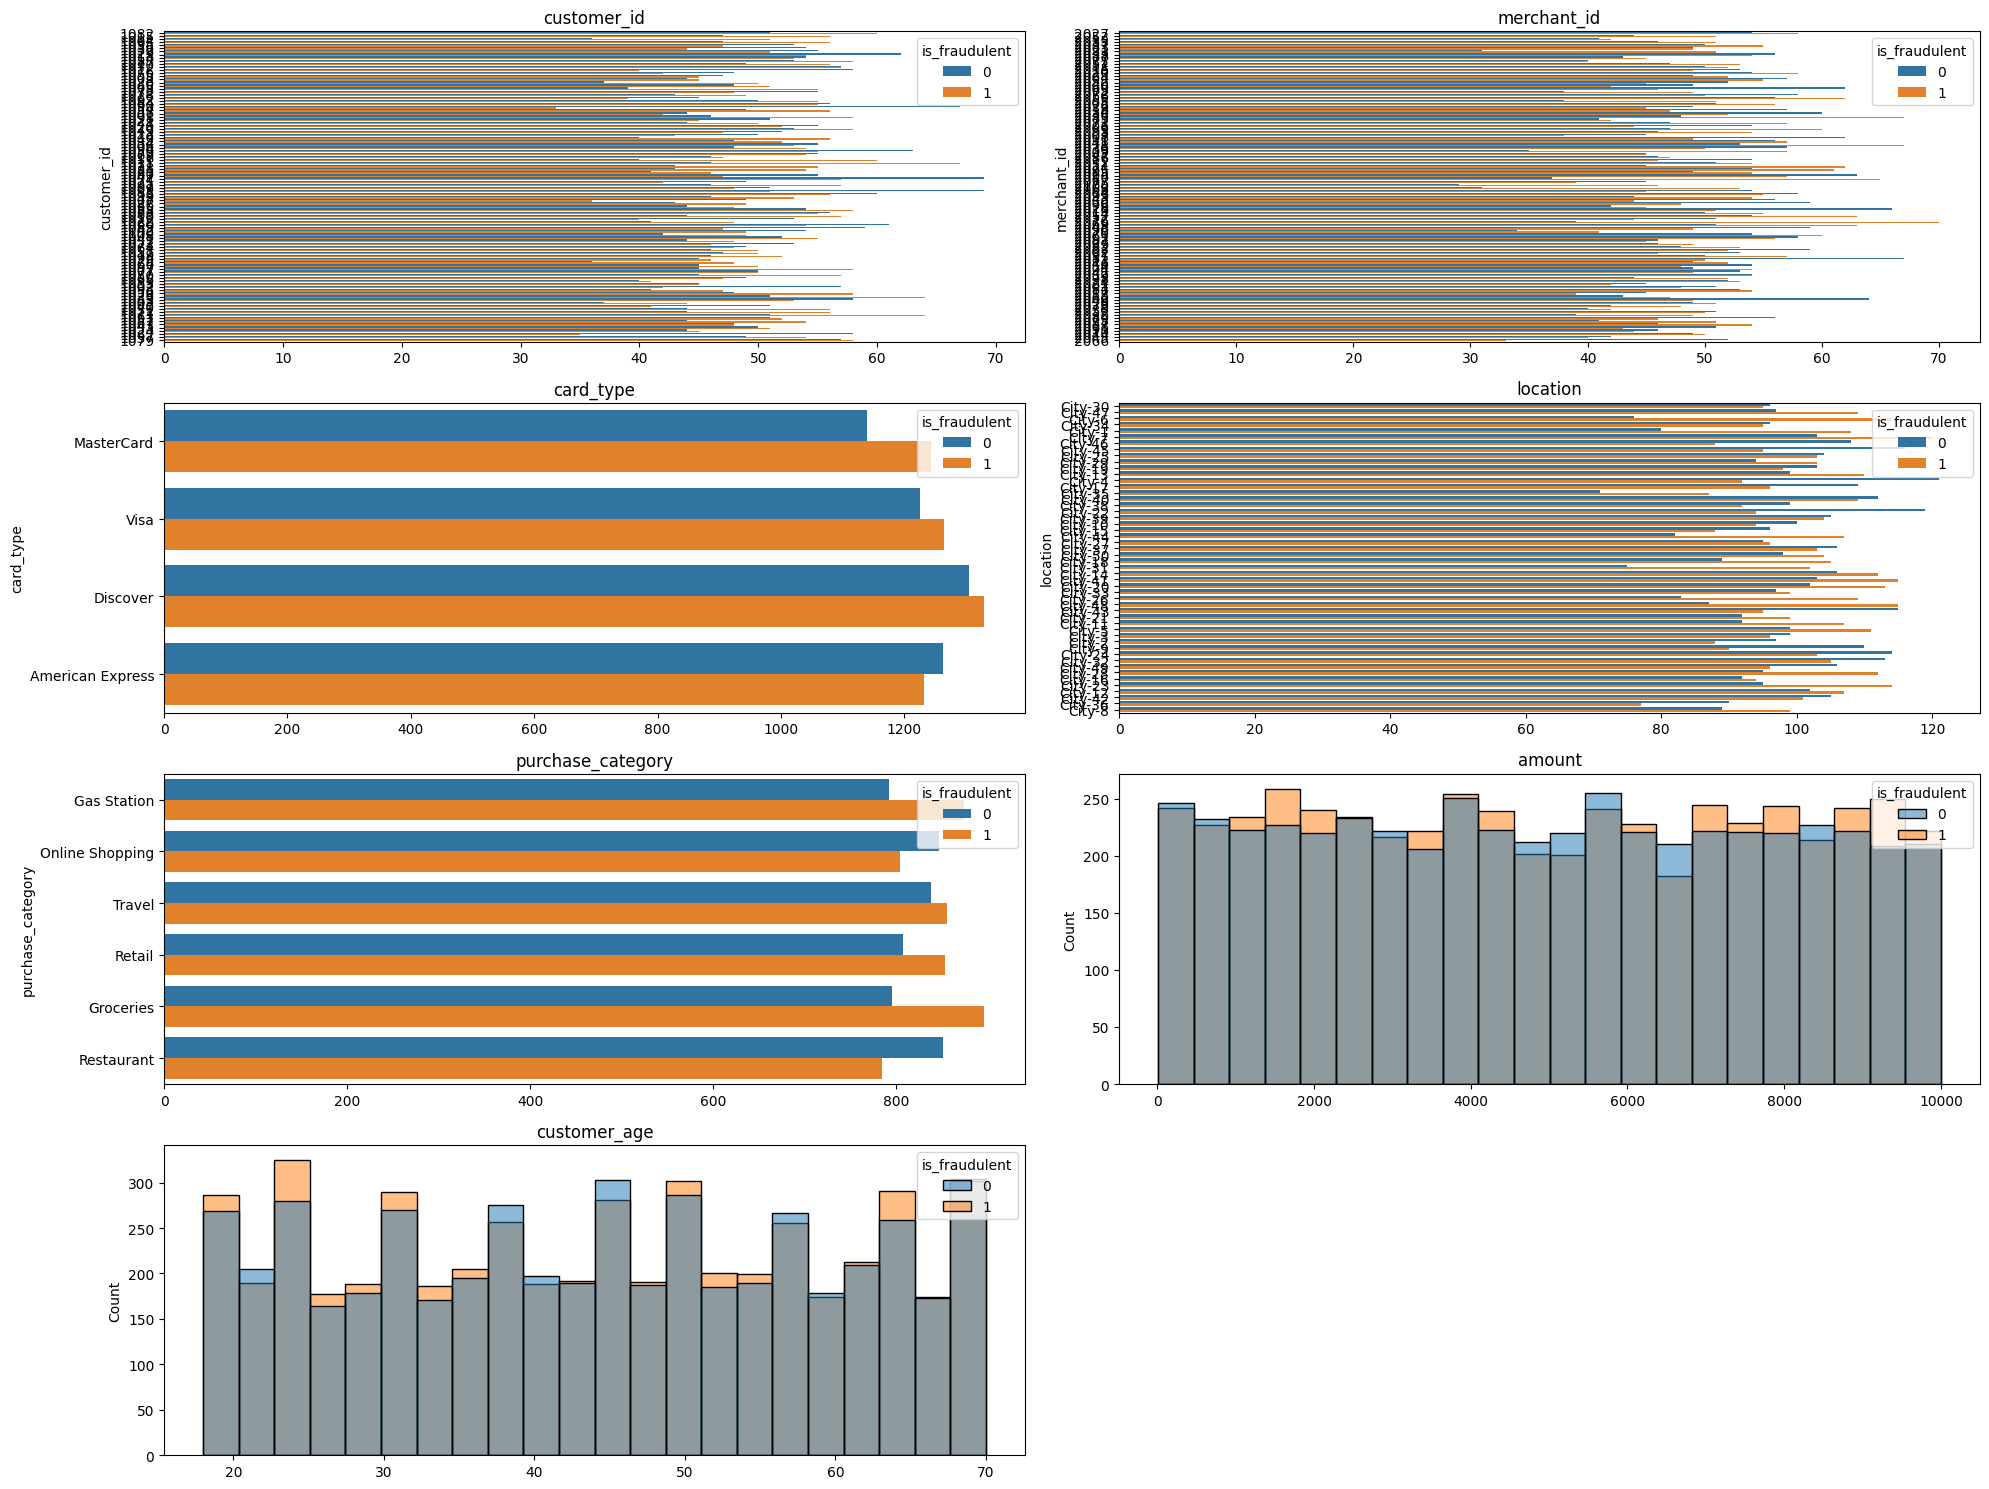

In [176]:
fig, axes = plt.subplots(nrows = math.ceil(len(df.columns.drop("is_fraudulent"))/2), ncols = 2, figsize = (20,15))

axes = axes.flat

for i, col in enumerate(cat_cols):
    sns.countplot(data = df, y = col, ax = axes[i], hue = "is_fraudulent")
    axes[i].set_xlabel("")
    axes[i].set_title(col)

for j, col in enumerate(num_cols, start = i+1):
    sns.histplot(data = df, x = col, ax = axes[j], hue = "is_fraudulent")
    axes[j].set_xlabel("")
    axes[j].set_title(col)

if len(df.columns.drop("is_fraudulent"))%2 != 0:
    plt.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [178]:
detectar_orden_cat(cat_cols, "is_fraudulent")

Estamos evaluando la variable CUSTOMER_ID


is_fraudulent,0,1
customer_id,,
1001,44,42
1002,45,45
1003,37,44
1004,36,51
1005,47,45
...,...,...
1096,46,52
1097,45,50
1098,46,58


Para la categoría CUSTOMER_ID NO hay diferencias significativas, p = 0.8013

--------------------------------------------------------------------------------
Estamos evaluando la variable MERCHANT_ID


is_fraudulent,0,1
merchant_id,,
2001,45,42
2002,59,52
2003,46,54
2004,49,52
2005,38,51
...,...,...
2096,59,48
2097,53,46
2098,44,52


Para la categoría MERCHANT_ID NO hay diferencias significativas, p = 0.6912

--------------------------------------------------------------------------------
Estamos evaluando la variable CARD_TYPE


is_fraudulent,0,1
card_type,,
American Express,1262,1232
Discover,1304,1329
MasterCard,1140,1243
Visa,1226,1264


Para la categoría CARD_TYPE NO hay diferencias significativas, p = 0.2861

--------------------------------------------------------------------------------
Estamos evaluando la variable LOCATION


is_fraudulent,0,1
location,,
City-1,80,108
City-10,100,94
City-11,92,107
City-12,102,107
City-13,99,110
City-14,106,112
City-15,96,88
City-16,92,94
City-17,109,96


Para la categoría LOCATION NO hay diferencias significativas, p = 0.1815

--------------------------------------------------------------------------------
Estamos evaluando la variable PURCHASE_CATEGORY


is_fraudulent,0,1
purchase_category,,
Gas Station,792,874
Groceries,796,896
Online Shopping,847,804
Restaurant,851,785
Retail,808,853
Travel,838,856


Para la categoría PURCHASE_CATEGORY SÍ hay diferencias significativas, p = 0.0208


is_fraudulent,0,1
purchase_category,,
Gas Station,822.0,844.0
Groceries,834.0,858.0
Online Shopping,814.0,837.0
Restaurant,807.0,829.0
Retail,819.0,842.0
Travel,835.0,859.0


--------------------------------------------------------------------------------


### Encoding

Vamos a realizar el encoding de las variables categóricas. Teniendo en cuenta que las categóricas de ids contienen muchas categorías, es razonable (aunque no presenten diferencias muy significativas) realizar target encoding en esas, ya que codificaremos con la media de fraudulencia de cada uno de los ids. Aunque el encoding de cada uno va a ser bastante cercano, ya que no eran diferentes a nivel estadístico.

Para `card_type` sí que nos es asequible realizar un onehot ya que no tiene demasiadas categorías.

In [179]:
onehot = OneHotEncoder()
trans_one_hot = onehot.fit_transform(df[["card_type"]])
oh_df = pd.DataFrame(trans_one_hot.toarray(), columns=onehot.get_feature_names_out())

In [180]:
target_encoder = TargetEncoder()
encoded_cols = target_encoder.fit_transform(df.drop(columns = ["is_fraudulent", "card_type"]), df["is_fraudulent"])

In [181]:
df_encoded = pd.concat([df["is_fraudulent"], encoded_cols, oh_df], axis = 1)

### Feature Scaling

Vamos a usar un scaling inicial para esta iteración de MinMax, ya que lo encodeados por target considerando la VR de `is_fraudulent` estará contenido entre 0 y 1, por lo que un minmax sería una buena forma de estandarizar el resto de variables.

In [182]:
df_scaled, scaler = scale_data(data = df_encoded, columns=df_encoded.columns.drop("is_fraudulent"), method = "minmax")
df_scaled = pd.concat([df_encoded["is_fraudulent"], df_scaled], axis = 1)

### Outliers

Para los outliers, vamos un poco a ciegas ya que no tenemos forma de visualizar outliers univariantes en la variable respuesta, por lo que la única opción será comprobar multivariantes, mucho menos intuitivos de visualizar. Vamos a optar inicialmente por un ifo.

In [183]:
df_outliers, outlier_finder = find_outliers(data = df_scaled, columns = df_encoded.columns, method = "ifo")

100%|██████████| 25/25 [00:28<00:00,  1.16s/it]


In [184]:
df_outliers.sample(10)

,is_fraudulent,customer_id,merchant_id,amount,location,purchase_category,customer_age,card_type_American Express,card_type_Discover,card_type_MasterCard,card_type_Visa
30,1,0.000000,0.250314,0.445909,0.798528,0.900628,0.115385,0.0,0.0,1.0,0.0
5977,1,0.513912,0.765219,0.841709,0.107542,0.000000,0.865385,0.0,1.0,0.0,0.0
8015,1,0.948651,0.884606,0.046324,0.563265,0.000000,0.865385,1.0,0.0,0.0,0.0
9471,0,0.863377,0.910540,0.304395,0.000000,0.000000,0.865385,0.0,0.0,0.0,1.0
1798,1,0.513912,0.203370,0.953639,0.848092,0.000000,0.288462,0.0,0.0,1.0,0.0
7085,0,0.738567,0.178200,0.046363,0.055866,0.143774,0.903846,1.0,0.0,0.0,0.0
4107,1,1.000000,0.884606,0.947024,0.798528,1.000000,0.634615,0.0,0.0,1.0,0.0
597,0,0.973857,0.439720,0.897706,1.000000,0.000000,0.826923,0.0,0.0,1.0,0.0
4100,1,0.938225,0.510079,0.981078,1.000000,0.512530,0.211538,0.0,0.0,0.0,1.0
5095,0,0.349057,0.272151,0.022995,0.848092,0.000000,0.019231,0.0,1.0,0.0,0.0


Los datos obtenidos serán aquellos que presentan combinaciones de categóricas (y las numéricas) poco comunes. Habría que decidir qué hacer con estos datos, si imputarlos, eliminarlos o tratarlos, lo cual podremos evaluar tras obtener las métricas del modelo.